In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np

In [2]:
from fuzzywuzzy import process

#list_sensors = ['NUST- Pk 8', 'NUST- Pk 9',]
#correction_factors = {'NUSTpk-8': 1, 'NUSTpk-9': 1}
#process.extract('NUST- Pk 8', correction_factors.keys(), limit = 1)

/Users/darrenwu/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[('NUSTpk-8', 89)]

In [64]:
#PATH = r"/Users/darrenwu/Bergin_Research/pakistan"

correction_factors = {'NUSTpk-8': 1.05,
                      'NUSTpk-9': 1.03,
                      'NUSTpk-11': 1.16,
                      'NUSTpk-12': 1.12,
                      'NUSTpk-13': 1.05,
                      'NUSTpk-14': 1.28,
                      'NUSTpk-15': 1.05,
                      'NUSTpk-16': 1.42,
                      'NUSTpk-17': 1.15
                    }   

start_time = '2022-04-22 00:00:00'
end_time = '2022-04-24 11:59:59'


def method(correction_factors, start_time, end_time):
    raw_df = pd.DataFrame(columns = ['Filler'])
    new_df = pd.DataFrame(columns = ['Filler'])
    new_df_2 = pd.DataFrame(columns = ['Site Name', 'Slope', 'Intercept', 'R Value'])
    df = pd.read_csv('Level1_hourly.csv')

    df = df[(df['Timestamp (UTC)'] >= start_time) & (df['Timestamp (UTC)'] <= end_time)]

    for i in correction_factors.keys():
        
        name = process.extract(i, df['Site Name'], limit = 1)[0][0]



        hourly_data = df[df['Site Name'] == name][['Timestamp (UTC)', 'PM2.5 (ug/m3)']]
        #hours = df[df['Site Name'] == name]['Timestamp (UTC)']     

        hourly_data.rename(columns={'PM2.5 (ug/m3)': name}, inplace = True)

        if 'Timestamp (UTC)' not in raw_df.columns:
            raw_df = pd.concat([raw_df, hourly_data], axis=1) 
        else:
            raw_df = raw_df.merge(hourly_data, on = 'Timestamp (UTC)', how = 'left')

        hourly_data[name] = hourly_data[name].apply(lambda x: x / (correction_factors[i]))
        #rename

        if 'Timestamp (UTC)' not in new_df.columns:     
            new_df = pd.concat([new_df, hourly_data], axis=1) 
        else:
            new_df = new_df.merge(hourly_data, on = 'Timestamp (UTC)', how = 'left')

        #hourly_data_corrected.reset_index(inplace = True, drop = True)
        hourly_data.reset_index(inplace = True, drop = True)

        if len(hourly_data) < 1:
            continue

        #slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(hourly_data)), hourly_data)

        #new_df_2 = new_df_2.append({'Site Name': name, 'Slope': slope, 'Intercept': intercept, 'R Value': r_value}, ignore_index=True)

    new_df.drop(new_df.columns[0], axis = 1, inplace = True)
    raw_df.drop(raw_df.columns[0], axis = 1, inplace = True)

    new_df['Timestamp (UTC)']= pd.to_datetime(new_df['Timestamp (UTC)'])
    new_df['Timestamp (UTC)'] = new_df['Timestamp (UTC)'].dt.strftime('%m/%d %H')

    raw_df['Timestamp (UTC)']= pd.to_datetime(raw_df['Timestamp (UTC)'])
    raw_df['Timestamp (UTC)'] = raw_df['Timestamp (UTC)'].dt.strftime('%m/%d %H')

    #unaltered plot
    #print(new_df)
    raw_df.to_csv('pakistan_raw.csv')
    new_df.to_csv('pakistan_post.csv')

    #print(new_df[new_df.columns].corr(method = 'pearson'))

    #print('\n')

    #print(new_df_2)
    new_df_2.to_csv('pakistan1val2.csv')


method(correction_factors, start_time, end_time)


<function matplotlib.pyplot.show(close=None, block=None)>

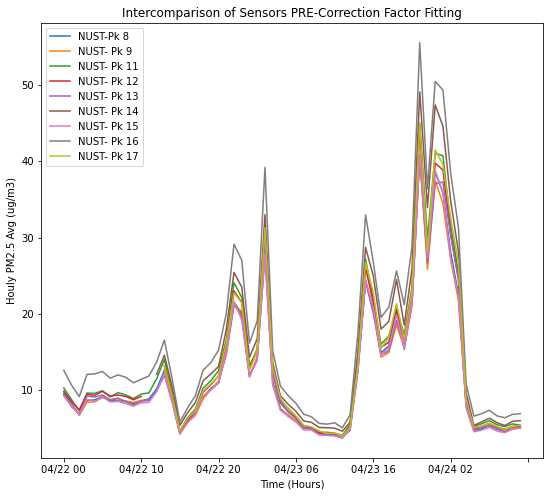

In [4]:
df = pd.read_csv('pakistanraw.csv')
ax = df.plot(x = 'Timestamp (UTC)', y= ['NUST-Pk 8', 'NUST- Pk 9', 'NUST- Pk 11', 'NUST- Pk 12', 'NUST- Pk 13', 'NUST- Pk 14', 'NUST- Pk 15', 'NUST- Pk 16', 'NUST- Pk 17'], kind="line", figsize=(9, 8))
ax.set_xlabel("Time (Hours)")
ax.set_ylabel("Houly PM2.5 Avg (ug/m3)")
ax.set_title('Intercomparison of Sensors PRE-Correction Factor Fitting')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

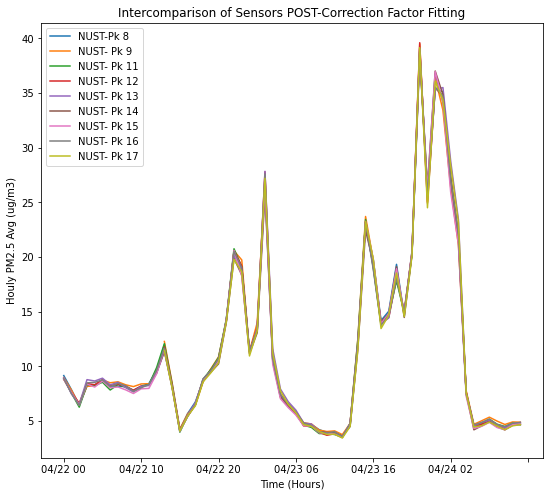

In [5]:
df = pd.read_csv('pakistan_post.csv')
ax = df.plot(x = 'Timestamp (UTC)', y = ['NUST-Pk 8', 'NUST- Pk 9', 'NUST- Pk 11', 'NUST- Pk 12', 'NUST- Pk 13', 'NUST- Pk 14', 'NUST- Pk 15', 'NUST- Pk 16', 'NUST- Pk 17'], kind="line", figsize=(9, 8))
ax.set_xlabel("Time (Hours)")
ax.set_ylabel("Houly PM2.5 Avg (ug/m3)")
ax.set_title('Intercomparison of Sensors POST-Correction Factor Fitting')
plt.show

In [4]:
#R^2, slope, intercept Matrix for hourly lvl 1 data

def intercomparison(input_csv):
    df = pd.read_csv(input_csv)
    df_size = len(df.columns)
    final = []
    for i in range(2, df_size):
        for j in range(2, df_size):
            
            y = np.array(df[df.columns[i]].values, dtype = float)
            #print(y)
            
            x = np.array(df[df.columns[j]].values, dtype = float)
            #print(x)

            if len(y) != len(x):
                min_row_size = min(len(y), len(x))

                y = y[0: min_row_size]
                x = x[0: min_row_size]

            mask = ~np.isnan(x) & ~np.isnan(y)
            slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])

            final_tuple_val = (round(slope, 3), round(intercept, 3), round(r_value, 3))
            final.append(final_tuple_val)


    new_final = np.empty(len(final), dtype = 'object')

    new_final[:] = final

    final_2d = np.reshape(new_final, (df_size - 2, df_size - 2))
    df_final = pd.DataFrame(final_2d, 
                            columns = ['NUST-Pk 8', 'NUST- Pk 9', 'NUST- Pk 11', 'NUST- Pk 12', 'NUST- Pk 13', 'NUST- Pk 14', 'NUST- Pk 15', 'NUST- Pk 16', 'NUST- Pk 17'],
                            index = ['NUST-Pk 8', 'NUST- Pk 9', 'NUST- Pk 11', 'NUST- Pk 12', 'NUST- Pk 13', 'NUST- Pk 14', 'NUST- Pk 15', 'NUST- Pk 16', 'NUST- Pk 17'],
                            dtype = object) 
    df_final.to_csv('matrix_post.csv')

input_csv = 'pakistan_post.csv'
intercomparison(input_csv)




In [19]:
#level 2 hourly

df = pd.read_csv('Level1_hourly.csv')

df = df[(df['Timestamp (UTC)'] >= start_time) & (df['Timestamp (UTC)'] <= end_time)][['Site Name', 'Timestamp (UTC)', 'PM2.5 (ug/m3)']]

separated_df = pd.DataFrame(columns = ['Filler'])

separated_df = pd.concat([separated_df, df[df['Site Name'] == 'NUST-Pk 8']], axis = 1)
separated_df = pd.concat([separated_df, df[df['Site Name'] == 'NUST- Pk 9']], axis = 1)

df[df['Site Name'] == 'NUST- Pk 9']

,Site Name,Timestamp (UTC),PM2.5 (ug/m3)
1112,NUST- Pk 9,2022-04-22 00:00:00,9.25
1113,NUST- Pk 9,2022-04-22 01:00:00,8.05
1114,NUST- Pk 9,2022-04-22 02:00:00,6.72
1115,NUST- Pk 9,2022-04-22 03:00:00,8.42
1116,NUST- Pk 9,2022-04-22 04:00:00,8.48
1117,NUST- Pk 9,2022-04-22 05:00:00,9.03
1118,NUST- Pk 9,2022-04-22 06:00:00,8.76
1119,NUST- Pk 9,2022-04-22 07:00:00,8.85
1120,NUST- Pk 9,2022-04-22 08:00:00,8.57
1121,NUST- Pk 9,2022-04-22 09:00:00,8.40
